In [1]:
import os, sys, re, gc

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.auto import tqdm, trange
from utils import JDNDataset, JDIModel, get_grey_image, assign_labels, accuracy



import seaborn as sns

2021-06-18 21:09:07,059 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-18 21:09:07,062 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-18 21:09:07,062 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-18 21:09:07,067 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-06-18 21:09:07,069 -INFO - dataset_builder:dataset_builder.py:207 - dataset package is loaded...
2021-06-18 21:09:07,071 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
DEVICE='cpu'

In [4]:
model = torch.load('model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=1732, out_features=128, bias=False)
  (batchNorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden1): Linear(in_features=128, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden2): Linear(in_features=32, out_features=22, bias=True)
)

## Load test dataset

In [5]:
# dataset_name = 'angular'
# dataset_name = 'html-5'
# dataset_name = 'react-ant'
# dataset_name = 'mobile-and-html-5'
# dataset_name = 'bootstrap'
# dataset_name = 'dummy'
# dataset_name = 'google'
# dataset_name = 'cnews'
dataset_name = 'login'


In [6]:
dataset = JDNDataset(datasets_list=[dataset_name])

  0%|          | 0/1 [00:00<?, ?it/s]

2021-06-18 21:09:11,454 -INFO - dataset:dataset.py:255 - self.df.shape: (231, 24)
2021-06-18 21:09:11,455 -INFO - dataset:dataset.py:257 - Check for duplicates...
2021-06-18 21:09:11,456 -INFO - dataset:dataset.py:261 - Check for duplicates is OK
2021-06-18 21:09:11,476 -INFO - features_builder:features_builder.py:228 - used column: tag_name
2021-06-18 21:09:11,477 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-18 21:09:11,479 -INFO - features_builder:features_builder.py:228 - used column: tag_name_parent
2021-06-18 21:09:11,480 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-18 21:09:11,482 -INFO - features_builder:features_builder.py:228 - used column: tag_name_upsib
2021-06-18 21:09:11,483 -INFO - features_builder:features_builder.py:231 - loading model/ohe_tag_name.pkl
2021-06-18 21:09:11,484 -INFO - features_builder:features_builder.py:228 - used column: tag_name_dnsib
2021-06-18 21:09:11,485 -INF

  0%|          | 0/231 [00:00<?, ?it/s]

2021-06-18 21:09:11,538 -INFO - features_builder:features_builder.py:152 - used column: attributes_parent


  0%|          | 0/231 [00:00<?, ?it/s]

2021-06-18 21:09:11,582 -INFO - features_builder:features_builder.py:152 - used column: attributes_upsib


  0%|          | 0/231 [00:00<?, ?it/s]

2021-06-18 21:09:11,624 -INFO - features_builder:features_builder.py:152 - used column: attributes_dnsib


  0%|          | 0/231 [00:00<?, ?it/s]

2021-06-18 21:09:11,665 -INFO - dataset_collector:dataset_collector.py:53 - attributes_sm: (231, 17)
2021-06-18 21:09:11,666 -INFO - features_builder:features_builder.py:188 - used column: attributes
2021-06-18 21:09:11,666 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...
2021-06-18 21:09:11,669 -INFO - features_builder:features_builder.py:188 - used column: attributes_parent
2021-06-18 21:09:11,670 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...
2021-06-18 21:09:11,672 -INFO - features_builder:features_builder.py:188 - used column: attributes_upsib
2021-06-18 21:09:11,673 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for class attribute exists. Loaging...
2021-06-18 21:09:11,676 -INFO - features_builder:features_builder.py:188 - used column: attributes_dnsib
2021-06-18 21:09:11,678 -INFO - features_builder:features_builder.py:191 - TfIdfVectorizer for

In [7]:
dataset.df.label.value_counts()

21    209
1      16
8       4
0       2
Name: label, dtype: int64

In [8]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1, pin_memory=True)

In [9]:
results = []
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = torch.round(torch.nn.Softmax(dim=1)(model(x.to(DEVICE)).to('cpu'))).detach().numpy()
            y_pred = y_pred[0].argmax()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df['is_hidden'] = dataset.df.is_hidden.values
results_df

  0%|          | 0/231 [00:00<?, ?it/s]

,y_true,y_pred,y_true_label,y_pred_label,is_hidden
0,21,1,n/a,link,0
1,21,1,n/a,link,0
2,21,21,n/a,n/a,1
3,21,21,n/a,n/a,1
4,21,21,n/a,n/a,0
...,...,...,...,...,...
226,21,21,n/a,n/a,0
227,21,21,n/a,n/a,0
228,21,21,n/a,n/a,1
229,21,21,n/a,n/a,0


In [10]:
list(dataset.classes_dict.keys())

['button',
 'link',
 'textfield',
 'dropdown',
 'checkbox',
 'radiobutton',
 'textarea',
 'fileinput',
 'iframe',
 'range',
 'progressbar',
 'datetimeselector',
 'colorpicker',
 'numberselector',
 'selector',
 'table',
 'switch',
 'slider',
 'tree-node',
 'steper',
 'tab',
 'n/a']

In [11]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=results_df.y_true_label.values,
                     y_pred=results_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    columns=list(dataset.classes_dict.keys()),
    index=list(dataset.classes_dict.keys())
)



In [12]:
confusion_matrix_df

,button,link,textfield,dropdown,checkbox,radiobutton,textarea,fileinput,iframe,range,...,colorpicker,numberselector,selector,table,switch,slider,tree-node,steper,tab,n/a
button,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
link,0,15,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
textfield,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdown,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textarea,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fileinput,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iframe,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
range,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
import seaborn as sns


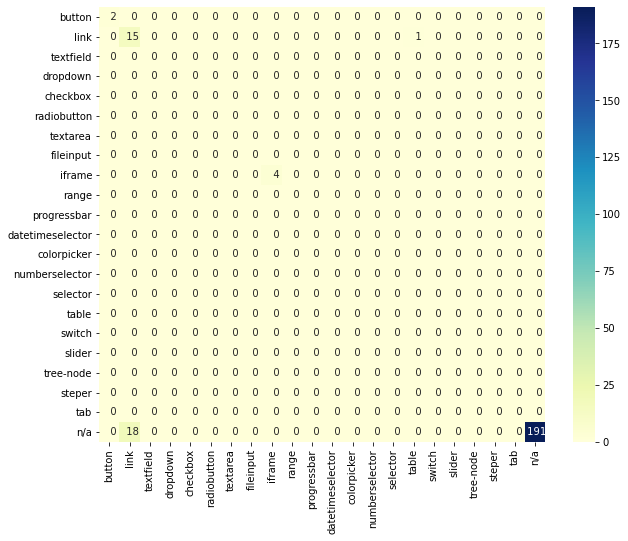

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu");

In [15]:
dataset_name

'login'

In [16]:
accuracy(results_df)

2021-06-18 21:09:20,155 -INFO - common:common.py:464 - Accuracy:  19/37 = 0.5135135135135135, for 231 elements


0.5135135135135135

In [17]:
dataset.classes_dict

{'button': 0,
 'link': 1,
 'textfield': 2,
 'dropdown': 3,
 'checkbox': 4,
 'radiobutton': 5,
 'textarea': 6,
 'fileinput': 7,
 'iframe': 8,
 'range': 9,
 'progressbar': 10,
 'datetimeselector': 11,
 'colorpicker': 12,
 'numberselector': 13,
 'selector': 14,
 'table': 15,
 'switch': 16,
 'slider': 17,
 'tree-node': 18,
 'steper': 19,
 'tab': 20,
 'n/a': 21}

In [20]:

dataset.df['label_text_predicted'] = results_df.y_pred_label.values


(1336, 1200)


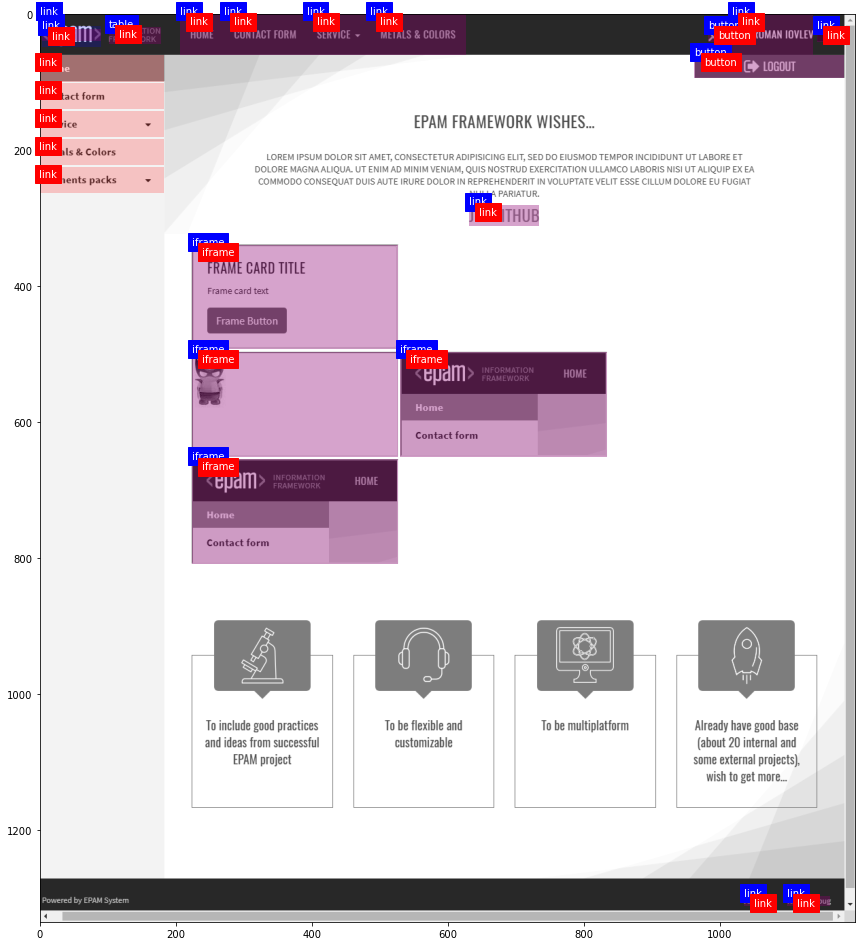

In [21]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.df[dataset.df.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted, color='white', backgroundcolor='blue')

for i, r in dataset.df[dataset.df.label != dataset.classes_dict['n/a']].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    




In [22]:
results_df

,y_true,y_pred,y_true_label,y_pred_label,is_hidden
0,21,1,n/a,link,0
1,21,1,n/a,link,0
2,21,21,n/a,n/a,1
3,21,21,n/a,n/a,1
4,21,21,n/a,n/a,0
...,...,...,...,...,...
226,21,21,n/a,n/a,0
227,21,21,n/a,n/a,0
228,21,21,n/a,n/a,1
229,21,21,n/a,n/a,0
